In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fftn, ifftn, fftfreq
from muFFT import FFT
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = [8, 8]


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

def curl_muFFT(u_cxyz):
    u_x, u_y, u_z = u_cxyz

    u_x_rfield = fft.real_space_field('u_x rf')
    u_y_rfield = fft.real_space_field('u_y rf')
    u_z_rfield = fft.real_space_field('u_z rf')

    u_x_ffield = fft.fourier_space_field('u_x ff')
    u_y_ffield = fft.fourier_space_field('u_y ff')
    u_z_ffield = fft.fourier_space_field('u_z ff')

    u_x_rfield.p = u_x
    u_y_rfield.p = u_y
    u_z_rfield.p = u_z

    fft.fft(u_x_rfield, u_x_ffield)
    fft.fft(u_y_rfield, u_y_ffield)
    fft.fft(u_z_rfield, u_z_ffield)

    xfgrad = fft.fourier_space_field('xfgrad')
    yfgrad = fft.fourier_space_field('yfgrad')
    zfgrad = fft.fourier_space_field('zfgrad')

    kx = 2 * np.pi * fft.fftfreq[0]
    ky = 2 * np.pi * fft.fftfreq[1]
    kz = 2 * np.pi * fft.fftfreq[2]

    #print(xfgrad.p.shape)
    #print(u_z_ffield.p.shape)
    #print(u_y_ffield.p.shape)

    #print(fft.fftfreq.shape)

    xfgrad.p = 1j * ky * u_z_ffield.p - 1j * kz * u_y_ffield.p
    yfgrad.p = 1j * kz * u_x_ffield.p - 1j * kx * u_z_ffield.p
    zfgrad.p = 1j * kx * u_y_ffield.p - 1j * ky * u_x_ffield.p

    xgrad = fft.real_space_field('xgrad')
    ygrad = fft.real_space_field('ygrad')
    zgrad = fft.real_space_field('zgrad')

    fft.ifft(xfgrad, xgrad)
    fft.ifft(yfgrad, ygrad)
    fft.ifft(zfgrad, zgrad)

    curl_x = xgrad.p * fft.normalisation
    curl_y = ygrad.p * fft.normalisation
    curl_z = zgrad.p * fft.normalisation

    curl_u_xyz = np.array([curl_x, curl_y, curl_z])
    
    return curl_u_xyz

In [3]:

def curl_muFFT_2D(u_cxyz):
    print("curl_muFFT_2D")
    # print(u_cxyz.shape)

    u_x, u_y = u_cxyz

    u_x_rfield = fft.real_space_field('u_x rf')
    u_y_rfield = fft.real_space_field('u_y rf')

    u_x_ffield = fft.fourier_space_field('u_x ff')
    u_y_ffield = fft.fourier_space_field('u_y ff')

    u_x_rfield.p = u_x
    u_y_rfield.p = u_y

    fft.fft(u_x_rfield, u_x_ffield)
    fft.fft(u_y_rfield, u_y_ffield)

    xfgrad = fft.fourier_space_field('xfgrad')
    yfgrad = fft.fourier_space_field('yfgrad')

    kx = 2 * np.pi * fft.fftfreq[0]
    ky = 2 * np.pi * fft.fftfreq[1]

    #print(xfgrad.p.shape)
    #print(u_z_ffield.p.shape)
    #print(u_y_ffield.p.shape)

    #print(fft.fftfreq.shape)

    xfgrad.p = 1j * ky * u_x_ffield.p - 1j * kx * u_y_ffield.p
    yfgrad.p = 1j * kx * u_y_ffield.p - 1j * ky * u_x_ffield.p

    xgrad = fft.real_space_field('xgrad')
    ygrad = fft.real_space_field('ygrad')

    fft.ifft(xfgrad, xgrad)
    fft.ifft(yfgrad, ygrad)

    curl_x = xgrad.p * fft.normalisation
    curl_y = ygrad.p * fft.normalisation

    curl_u_xyz = np.array([curl_x, curl_y])

    # print(curl_u_xyz.shape)
    
    return curl_u_xyz

In [4]:
def rk4(f, t: float, y: np.ndarray, dt: float) -> np.ndarray:
    """
    Implements the fourth-order Runge-Kutta method for numerical integration
    of multidimensional fields.

    Parameters
    ----------
    f : function
        The function to be integrated. It should take two arguments: time t
        and field y.
    t : float
        The current time.
    y : array_like
        The current value of the field.
    dt : float
        The time step for the integration.

    Returns
    -------
    dy : np.ndarray
        The increment of the field required to obtain the value at t + dt.
    """
    k1 = f(t, y)
    k2 = f(t + dt / 2, y + dt / 2 * k1)
    k3 = f(t + dt / 2, y + dt / 2 * k2)
    k4 = f(t + dt, y + dt * k3)
    return dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)


def rhs(t, y):
    # print(y)
    # Right-hand side of the Navier-Stokes equations in Fourier space
    # print(y.shape)
    u_hat, v_hat = np.split(y, 2)
    # print(u_hat.shape)
    # print(v_hat.shape)
    nonlinear = curl_muFFT_2D(y)
    # print(nonlinear.shape)
    u_rhs_hat = nonlinear + nu * X**2 * u_hat
    v_rhs_hat = nonlinear + nu * Y**2 * v_hat
    # u_rhs_hat.reshape((N)), v_rhs_hat.reshape((N))
    print("sol")
    # print(u_rhs_hat.shape)
    # print(v_rhs_hat.shape)
    # print(u_rhs_hat[0].shape)
    # print(v_rhs_hat[0].shape)
    sol = np.array((u_rhs_hat[0], v_rhs_hat[0]))
    print(sol.shape)
    return sol


# Parameters
N = 16  # Grid size
L = 2 * np.pi  # Domain size
nu = 0.01  # Kinematic viscosity
dt = 0.1  # Time step
T = 100 # Total simulation time

nb_grid_pts = (N, N)
fft = FFT(nb_grid_pts, engine='pocketfft')

# Grid setup
x = np.linspace(0, L, N, endpoint=False)
y = np.linspace(0, L, N, endpoint=False)
X, Y = np.meshgrid(x, y)

# Wavenumbers for Fourier space
KX = fftfreq(N, d=L/N) * L
KY = fftfreq(N, d=L/N) * L

# Initial condition: Taylor-Green vortex
A = 1.0
B = 1.0
u_hat = A * np.cos(X) * np.sin(Y)
v_hat = B * np.sin(X) * -np.cos(Y)

y = np.array([u_hat, v_hat])

def analytical_solution(t, A, nu, X, Y):
    u_x = A * np.cos(X) * np.sin(Y) * np.exp(-2 * nu * t)
    u_y = -A * np.sin(X) * np.cos(Y) * np.exp(-2 * nu * t)
    return u_x, u_y

# Main time-stepping loop
t = 0
while t < T:
    u_analytical, v_analytical = analytical_solution(t, A, nu, X, Y)
    # print(y.shape)
    dy = rk4(rhs, t, y, dt)
    y += dy
    t += dt
    # print(f"Time: {t}, Average:")
    # print(np.average(dy[0]))
    # print(np.average(dy[1]))
    # print(np.average(y[0]))
    # print(np.average(y[1]))
    # print(np.average(u_analytical))
    # print(np.average(v_analytical))
    error_u = y[0] - u_analytical
    error_v = y[1] - v_analytical
    print(f"Time: {t}, Error:")
    # print(np.average(error_u))
    # print(np.average(error_v))
    print(y - np.array([u_analytical, v_analytical]))
    


(2, 16, 16)
curl_muFFT_2D
sol
(2, 16, 16)
curl_muFFT_2D
sol
(2, 16, 16)
curl_muFFT_2D
sol
(2, 16, 16)
curl_muFFT_2D
sol
(2, 16, 16)
Time: 0.001, Average:
-2.541098841762901e-21
-3.3819279344230536e-21
5.404070203482436e-19
-6.053787487418337e-19
-2.168404344971009e-19
-2.168404344971005e-19
Time: 0.001, Error:
-3.3203691532368573e-19
-1.0576931018047113e-18
[[[ 1.81633754e-08 -5.04382642e-09  4.22828021e-08  1.34219618e-08
    5.22626291e-08  1.34059533e-08  4.22471951e-08 -5.08055497e-09
    1.81003316e-08 -3.12094505e-08 -6.03563769e-09 -4.96753423e-08
   -1.60234112e-08 -4.96589017e-08 -6.01327778e-09 -3.11562633e-08]
  [-8.81053953e-08 -1.14448931e-04 -2.10756156e-04 -2.75499278e-04
   -3.00356390e-04 -2.83144251e-04 -2.27366061e-04 -1.41632566e-04
   -3.76994527e-05  7.08191612e-05  1.70737845e-04  2.50205789e-04
    3.00437320e-04  3.15675294e-04  2.94241100e-04  2.37556425e-04]
  [-1.80993755e-07 -2.11565028e-04 -3.89646274e-04 -5.09301469e-04
   -5.55289347e-04 -5.23427498e-04 

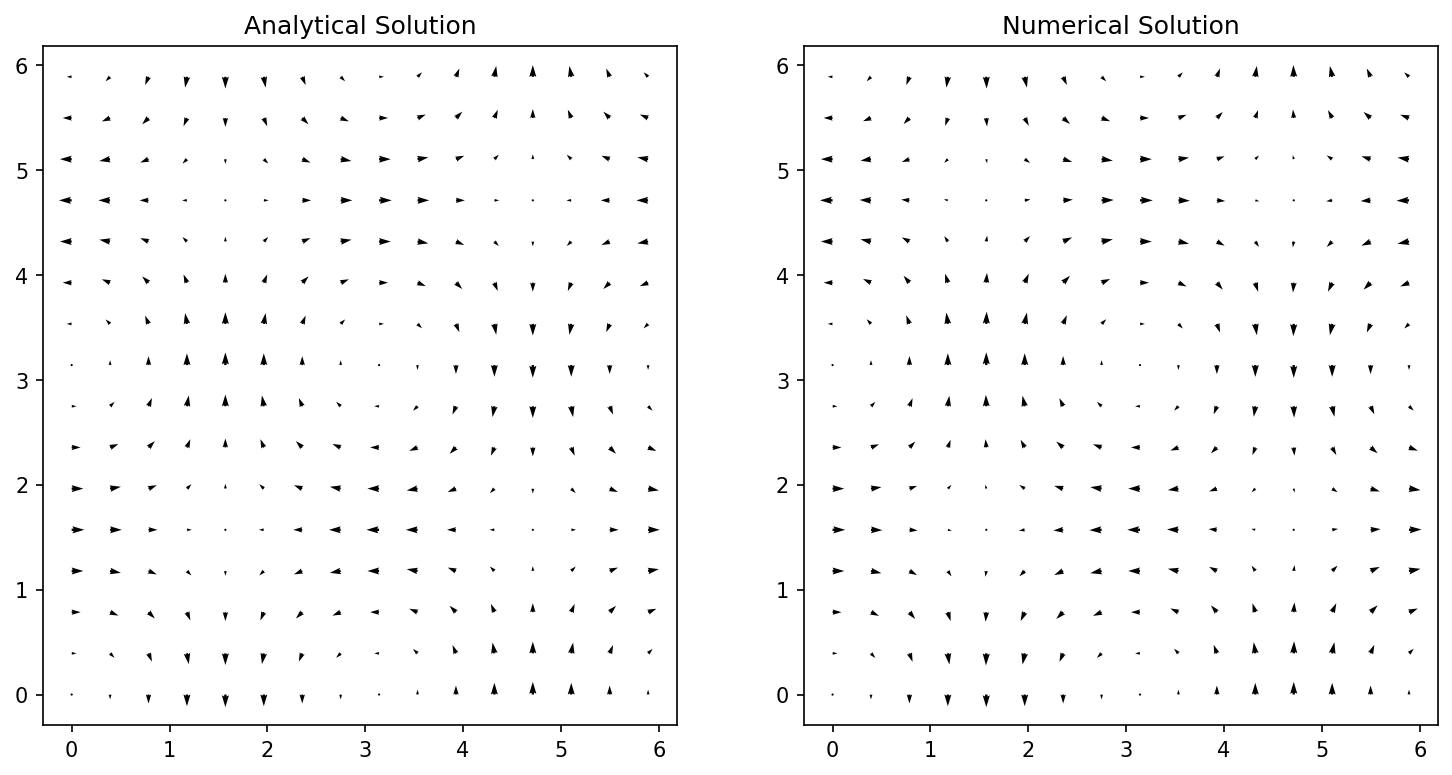

Error in u: [[ 2.20304326e-04 -6.67133948e-05  3.90463006e-04  6.82657519e-05
   4.50464949e-04  5.32270336e-05  3.56747855e-04 -1.01315796e-04
   1.61220174e-04 -3.05812409e-04 -2.40701114e-05 -4.40919695e-04
  -9.17577745e-05 -4.25094426e-04 -3.48870237e-06 -2.52111026e-04]
 [-3.66092509e-05 -1.04679784e-02 -1.94814260e-02 -2.57661262e-02
  -2.80093534e-02 -2.68071328e-02 -2.14638454e-02 -1.38826999e-02
  -3.87033100e-03  5.97312107e-03  1.59075390e-02  2.32258768e-02
   2.88173257e-02  3.01379775e-02  2.92166760e-02  2.30668581e-02]
 [-3.21678725e-04 -2.02924737e-02 -3.82326443e-02 -5.00712381e-02
  -5.47823172e-02 -5.19557678e-02 -4.18170699e-02 -2.65072807e-02
  -7.27859692e-03  1.23636840e-02  3.12718939e-02  4.57637809e-02
   5.59336453e-02  5.84995792e-02  5.58039976e-02  4.38392943e-02]
 [-5.41479394e-04 -2.65232740e-02 -5.02476865e-02 -6.55655946e-02
  -7.19358329e-02 -6.80182827e-02 -5.49100540e-02 -3.46210417e-02
  -9.59522599e-03  1.63655849e-02  4.09550896e-02  6.01398389

In [5]:
# Compute the analytical solution in real space
u_numerical = y[0]
v_numerical = y[1]

# Plot comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Analytical Solution")
plt.quiver(X, Y, u_analytical, v_analytical, scale=50)

plt.subplot(1, 2, 2)
plt.title("Numerical Solution")
plt.quiver(X, Y, u_numerical, v_numerical, scale=50)

plt.show()

# Calculate error
error_u = u_numerical - u_analytical
error_v = v_numerical - v_analytical
print(f"Error in u: {error_u}")
print(f"Error in v: {error_v}")


In [6]:
print("u_numerical:")
print(u_numerical)
print("v_numerical:")
print(v_numerical)

print("u_analytical:")
print(u_analytical)
print("v_analytical:")
print(v_analytical)

u_numerical:
[[ 2.20304326e-04 -6.67133948e-05  3.90463006e-04  6.82657519e-05
   4.50464949e-04  5.32270336e-05  3.56747855e-04 -1.01315796e-04
   1.61220174e-04 -3.05812409e-04 -2.40701114e-05 -4.40919695e-04
  -9.17577745e-05 -4.25094426e-04 -3.48870237e-06 -2.52111026e-04]
 [ 3.81889860e-01  3.42386069e-01  2.50581370e-01  1.20390806e-01
  -2.80093534e-02 -1.72964065e-01 -2.91526641e-01 -3.66736747e-01
  -3.85796800e-01 -3.46880926e-01 -2.54155257e-01 -1.22931055e-01
   2.88173257e-02  1.76294910e-01  2.99279472e-01  3.75920906e-01]
 [ 7.05386416e-01  6.31696791e-01  4.60778335e-01  2.19991558e-01
  -5.47823172e-02 -3.22018564e-01 -5.40828049e-01 -6.78496546e-01
  -7.12986692e-01 -6.39625581e-01 -4.67739086e-01 -2.24299015e-01
   5.59336453e-02  3.28562375e-01  5.54814977e-01  6.95828559e-01]
 [ 9.21510581e-01  8.25341753e-01  6.01741578e-01  2.87288453e-01
  -7.19358329e-02 -4.20872330e-01 -7.06899319e-01 -8.86486069e-01
  -9.31647287e-01 -8.35499442e-01 -6.11034175e-01 -2.9271420